In [32]:
import numpy as np
import matplotlib.pyplot as plt 
import csv

from scipy.interpolate import make_interp_spline, make_lsq_spline
import rpy2.robjects as robjects
import pyreadr
import sys
import csv

sys.path.append("../../src/Utility")

from utility import plot_multiple_roc
from os.path import exists

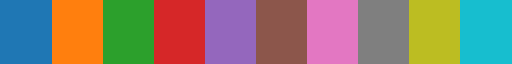

In [33]:
color_map = plt.get_cmap('tab10')
color_map

In [34]:
def remove_duplicate(x,y):
    """
    remove the duplicates in x
    """
    unique_v, idx, count = np.unique(x, return_inverse=True, return_counts=True)
    m = np.zeros((unique_v.size, 2))
    m[:,0] = unique_v
    duplicate_v = np.where(count>1)[0]
    for i in duplicate_v:
        j = np.where(idx==i)[0]
        mean_val = np.mean(y[j])
        m[ i, 1] = mean_val
    single_v = np.where(count==1)[0]
    for i in single_v:
        j = np.where(idx==i)[0]
        m[i,1] = y[j]
    return m


def remove_outlier(data_list, a=2):
    
    mean = np.mean(data_list)
    std = np.std(data_list)
    keep = np.intersect1d(np.where(data_list <= mean + a*std)[0], np.where(data_list >= mean - a*std)[0])
    keep = np.array(keep)

    out = [data_list[x] for x in keep]
    return out, keep

In [35]:
def calculate_auc(m):
    #m is ndarray and m[:,0] denotes the fpr and m[:,1] are tpr
    m = np.vstack(([0.,0.],m))
    #print(m)
    X_Y_Spline = make_interp_spline(m[:,0], m[:,1], k=1)
    X_ = 1
    Y_ = min(X_Y_Spline(X_),1)

    x_sort = np.sort(m[:,0])
    sort_id = np.argsort(m[:, 0])
    y_sort = m[sort_id, 1]
    x_sort = np.concatenate(( x_sort, [1]))
    y_sort = np.concatenate((y_sort, [Y_]))
    n = x_sort.size
    area = 0
    for i in range(n-1):
        x_interval = x_sort[i+1]-x_sort[i]
        y_average = (y_sort[i] + y_sort[i+1])/2
        area += x_interval*y_average
    return area


def calculate_auc15(m):
    #m is ndarray and m[:,0] denotes the fpr and m[:,1] are tpr
    m = np.vstack(([0.,0.],m))
    X_Y_Spline = make_interp_spline(m[:,0], m[:,1], k=1)
    X_ = 0.15
    Y_ = min(X_Y_Spline(X_),1)

    #print('x original', m[:,0])
    #print('y original', m[:,1])
    id = np.where(m[:,0]<=0.15)[0]
    x = m[id,0]
    y = m[id,1]
    x_sort = np.sort(x)
    
    sort_id = np.argsort(x)
    y_sort = y[sort_id]
    x_sort = np.concatenate((x_sort, [0.15]))
    
    y_sort = np.concatenate((y_sort, [Y_]))
    #print('x', x_sort)
    #print('y', y_sort)
    n = x_sort.size
    area = 0
    for i in range(n-1):
        x_interval = x_sort[i+1]-x_sort[i]
        y_average = (y_sort[i] + y_sort[i+1])/2
        area += x_interval*y_average
    return area/0.15



In [36]:
def mean_auc(original_list, keep_index, bin_size=50):
    interval = 1./ bin_size
    count = np.zeros(bin_size)
    tpr_avg = np.zeros(bin_size)
    for i in keep_index:    
        m = original_list[i]
        for j, x in enumerate(m[:,0]):
            x_id = int(x//interval)
            tpr_avg[x_id] += m[j,1]
            count[x_id] += 1
    nonzero_id = np.where(count > 0)
    tpr_out = tpr_avg[nonzero_id]/count[nonzero_id]
    fpr_out = np.arange(0,1,interval)[nonzero_id]
    return np.vstack((fpr_out, tpr_out)).T


        


In [37]:
def plot_mean_auc(ax, model_path, rest_of_name, label, linestyle, color):

    auc_r = []
    m_list = []
    for i in range(10):
        p_file = model_path+"ss_{}/".format(i+1)+rest_of_name
        if(exists(p_file)):

            arr = np.load(p_file)
            sort_fpr = np.argsort(arr[:,1])

            flng = np.zeros(arr.shape)
            flng[:,0] = arr[sort_fpr,0]
            flng[:,1] = arr[sort_fpr,1]

            m = remove_duplicate(flng[:,1], flng[:,0])
            m_list.append(m)
            auc_r.append(calculate_auc(m))
        else:
            print('file does not exist:{}'.format(p_file))

    
    _, keep_id = remove_outlier(auc_r)
    #print(keep_id)
    fpr_tpr = mean_auc(m_list, keep_id, bin_size=10)
    ax.plot(np.hstack((0.,fpr_tpr[:,0], 1.)), np.hstack((0.,fpr_tpr[:,1], 1.)), linestyle=linestyle,  label=label, color=color)


    #plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='dashed', color = color_map(9))

def plot_mean_auc_joint(ax, model_path, rest_of_name, label, linestyle, color):
    
    
    auc_q = []
    mq_list = []    
    auc_z = []
    mz_list = [] 
    for i in range(10):
        comparison_filepath = model_path+"ss_{}/".format(i+1) + rest_of_name
        
        if(exists(comparison_filepath)):
            obj = pyreadr.read_r(comparison_filepath)

            qiao_fpr = np.array(obj['roc']['FPR.qiao'])
            qiao_tpr = np.array(obj['roc']['TPR.qiao'])

            sort_fpr = np.argsort(qiao_fpr)

            qiao = np.zeros((qiao_tpr.shape[0], 2))
            qiao[:,0] = qiao_fpr[sort_fpr]
            qiao[:,1] = qiao_tpr[sort_fpr]
            m = remove_duplicate(qiao[:,0], qiao[:,1])

            mq_list.append(m)
            auc_q.append(calculate_auc(m))


            zapata_fpr = np.array(obj['roc']['FPR.zapata'])
            zapata_tpr = np.array(obj['roc']['TPR.zapata'])
            sort_fpr = np.argsort(zapata_fpr)

            zapata = np.zeros((zapata_tpr.shape[0],2))
            zapata[:,0] = zapata_fpr[sort_fpr]
            zapata[:,1] = zapata_tpr[sort_fpr]
            m = remove_duplicate(zapata[:,0], zapata[:,1])

            mz_list.append(m)
            auc_z.append(calculate_auc(m))

    _, keep_id = remove_outlier(auc_q,1)
    #print(keep_id)
    fpr_tpr = mean_auc(mq_list, keep_id, bin_size=10)
    ax.plot(np.hstack((0.,fpr_tpr[:,0], 1.)), np.hstack((0.,fpr_tpr[:,1], 1.)), linestyle=linestyle[0],  label=label[0], color=color[0])

    _, keep_id = remove_outlier(auc_z)
    #print(keep_id)
    fpr_tpr = mean_auc(mz_list, keep_id, bin_size=10)
    ax.plot(np.hstack((0.,fpr_tpr[:,0], 1.)), np.hstack((0.,fpr_tpr[:,1], 1.)), linestyle=linestyle[1],  label=label[1], color=color[1])



def plot_mean_auc_jfggm(ax, model_path, rest_of_name, label, linestyle, color):
    
    
    auc_m = []
    mm_list = []    

    for i in range(10):
        comparison_filepath = model_path+"ss_{}/".format(i+1) + rest_of_name
        
        if(exists(comparison_filepath)):
            obj = pyreadr.read_r(comparison_filepath)

            jfggm_fpr = np.array(obj['roc']['FPR.jfggm'])
            jfggm_tpr = np.array(obj['roc']['TPR.jfggm'])

            test_num = len(obj['roc']['TPR.jfggm']) // 50
            max_area = 0
            max_i = -1

            #select b that has the largest ROC
            for i in range(test_num):
                tpr_jfggm = obj['roc']['TPR.jfggm'][i*50:(i+1)*50]
                fpr_jfggm = obj['roc']['FPR.jfggm'][i*50:(i+1)*50]
                m = remove_duplicate(fpr_jfggm , tpr_jfggm)
                area = calculate_auc(m)
                #print("index: " , i, " area: ", area)
                if area >= max_area:
                    max_area = area
                    max_i = i

            #print(max_i)
            tpr_jfggm = obj['roc']['TPR.jfggm'][max_i*50:(max_i+1)*50]
            fpr_jfggm = obj['roc']['FPR.jfggm'][max_i*50:(max_i+1)*50]
            
            sort_fpr = np.argsort(jfggm_fpr)

            jfggm = np.zeros((jfggm_tpr.shape[0],2))
            jfggm[:,0] = jfggm_fpr[sort_fpr]
            jfggm[:,1] = jfggm_tpr[sort_fpr]
            #print(jfggm.shape)
            m = remove_duplicate(jfggm[:,0], jfggm[:,1])
            mm_list.append(m)
            auc_m.append(calculate_auc(m))


    _, keep_id = remove_outlier(auc_m)
    #print(keep_id)
    fpr_tpr = mean_auc(mm_list, keep_id, bin_size=10)
    ax.plot(np.hstack((0.,fpr_tpr[:,0], 1.)), np.hstack((0.,fpr_tpr[:,1], 1.)), linestyle=linestyle,  label=label, color=color)



def plot_mean_auc_nr(ax, model_path, rest_of_name, label, linestyle, color):
    
    
    auc_m = []
    mm_list = []   
    auc_m15 = [] 

    for i in range(10):
        comparison_filepath = model_path+"ss_{}/".format(i+1) + rest_of_name
        
        if(exists(comparison_filepath)):
            obj = pyreadr.read_r(comparison_filepath)

            nr_fpr = np.array(obj['roc']['FPR.and'])
            nr_tpr = np.array(obj['roc']['TPR.and'])


            
            sort_fpr = np.argsort(nr_fpr)

            nr = np.zeros((nr_tpr.shape[0],2))
            nr[:,0] = nr_fpr[sort_fpr]
            nr[:,1] = nr_tpr[sort_fpr]
            #print(jfggm.shape)
            m = remove_duplicate(nr[:,0], nr[:,1])
            mm_list.append(m)
            auc_m.append(calculate_auc(m))
            auc_m15.append(calculate_auc15(m))

    _, keep_id = remove_outlier(auc_m)
    _, keep_id15 = remove_outlier(auc_m15)
    #print(rest_of_name)
    #print('NR AUC:', np.mean(np.array(auc_m)[keep_id]), np.std(np.array(auc_m)[keep_id]))
    #print('NR AUC15:', np.mean(np.array(auc_m15)[keep_id15]), np.std(np.array(auc_m15)[keep_id15]))


    fpr_tpr = mean_auc(mm_list, keep_id, bin_size=10)
    ax.plot(np.hstack((0.,fpr_tpr[:,0], 1.)), np.hstack((0.,fpr_tpr[:,1], 1.)), linestyle=linestyle,  label=label, color=color)



### Plot ROC with Noise Model 2

file does not exist:../../results/noise_model_2/model3/ss_7/model3_power_p150_N100_Iest_noise3_thre0.001_rate242_run8_tprfpr.npy
file does not exist:../../results/noise_model_2/model3/ss_8/model3_power_p150_N100_Iest_noise3_thre0.001_rate242_run8_tprfpr.npy
file does not exist:../../results/noise_model_2/model3/ss_9/model3_power_p150_N100_Iest_noise3_thre0.001_rate242_run8_tprfpr.npy
file does not exist:../../results/noise_model_2/model3/ss_10/model3_power_p150_N100_Iest_noise3_thre0.001_rate242_run8_tprfpr.npy


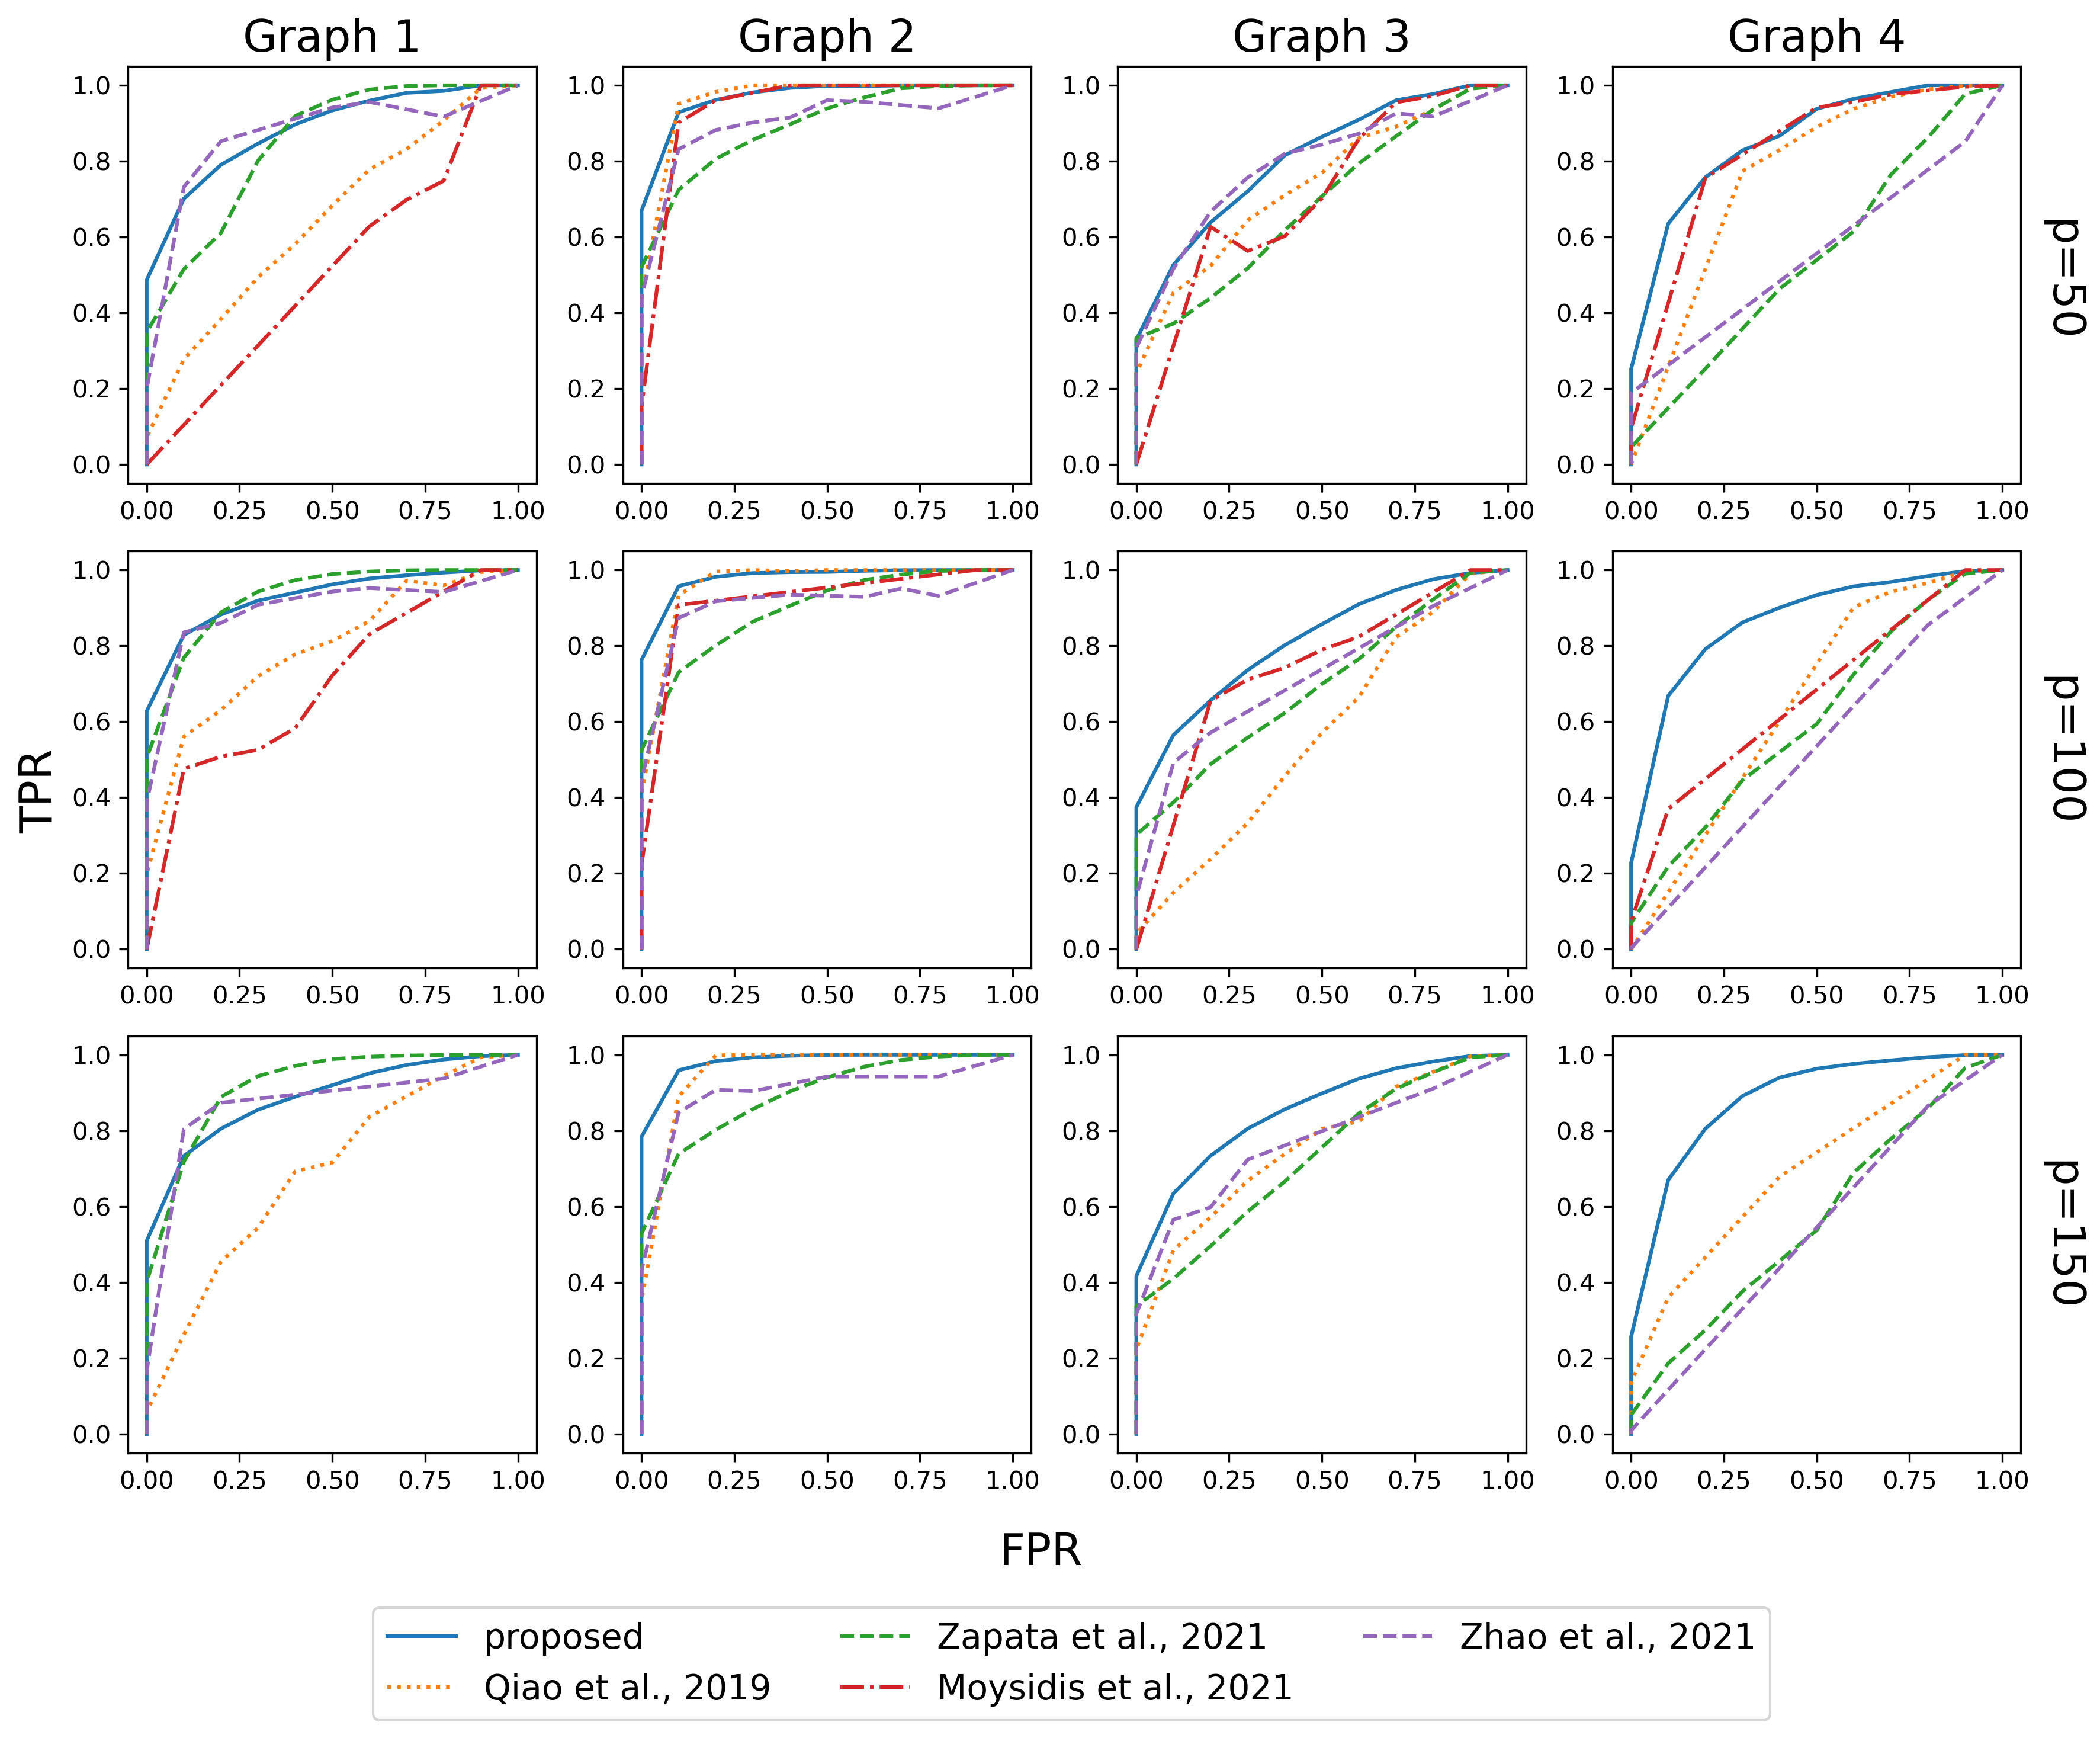

In [30]:
fig, ax = plt.subplots(3,4,figsize=(12, 9), dpi=300)
#for data20
rate_list = [[332, 342, 332], [232, 232, 242], [232, 443, 443], [232, 232, 242]]

name_list = ['tridiag1', 'tridiag2', 'tridiag3', 'power']
p_list = [50, 100, 150]
fig.supxlabel('FPR',fontsize=18)
fig.supylabel('TPR',fontsize=18)
for i, name in enumerate(name_list):
    for j, p in enumerate(p_list):
        if j == 0:
            ax[j,i].set_title("Graph {}".format(i+1), fontsize=18)
        if i == 3:
            ax[j,i].text(1.1, 0.35, 'p={}'.format(p_list[j]),  fontsize=18, rotation=-90)
        test_model = '{}_p{}_N100'.format(name, p)
        model_path = '../../results/noise_model_2/model3/'
        rest_of_name = 'model3_{}_Iest_noise3_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model, rate_list[i][j])

        plot_mean_auc( ax[j,i], model_path, rest_of_name, label='proposed', linestyle='solid', color=color_map(0))

        cmodel_path = '../../results/noise_model_2/comparison/'
        rest_of_name = '{}_noise3_light.RunInd4.Rdata'.format(test_model)

        nr_name = '{}_noise3_NR_RunInd4.Rdata'.format(test_model)
        plot_mean_auc_joint(ax[j,i], cmodel_path, rest_of_name, label=['Qiao et al., 2019', 'Zapata et al., 2021'], linestyle=['dotted', 'dashed'], color = [color_map(1), color_map(2)])
        
        rest_of_name = '{}_noise3_jfggm_stage2_100.RunInd1.Rdata'.format(test_model)

        if  j <= 1:
            plot_mean_auc_jfggm(ax[j,i], cmodel_path, rest_of_name, label='Moysidis et al., 2021', linestyle='dashdot', color=color_map(3))
        plot_mean_auc_nr(ax[j,i], cmodel_path, nr_name, label='Zhao et al., 2021', linestyle='dashed', color=color_map(4))
handles, labels = ax[0,0].get_legend_handles_labels()

fig.legend(handles, labels, ncol=3, bbox_to_anchor=(0.85, -0.0), prop={'size': 14})


fig.tight_layout()
#fig.savefig('compare_id20_average_horizontal2_rebuttal'+'.pdf', bbox_inches='tight')


### Plot ROC with Noise Model 1

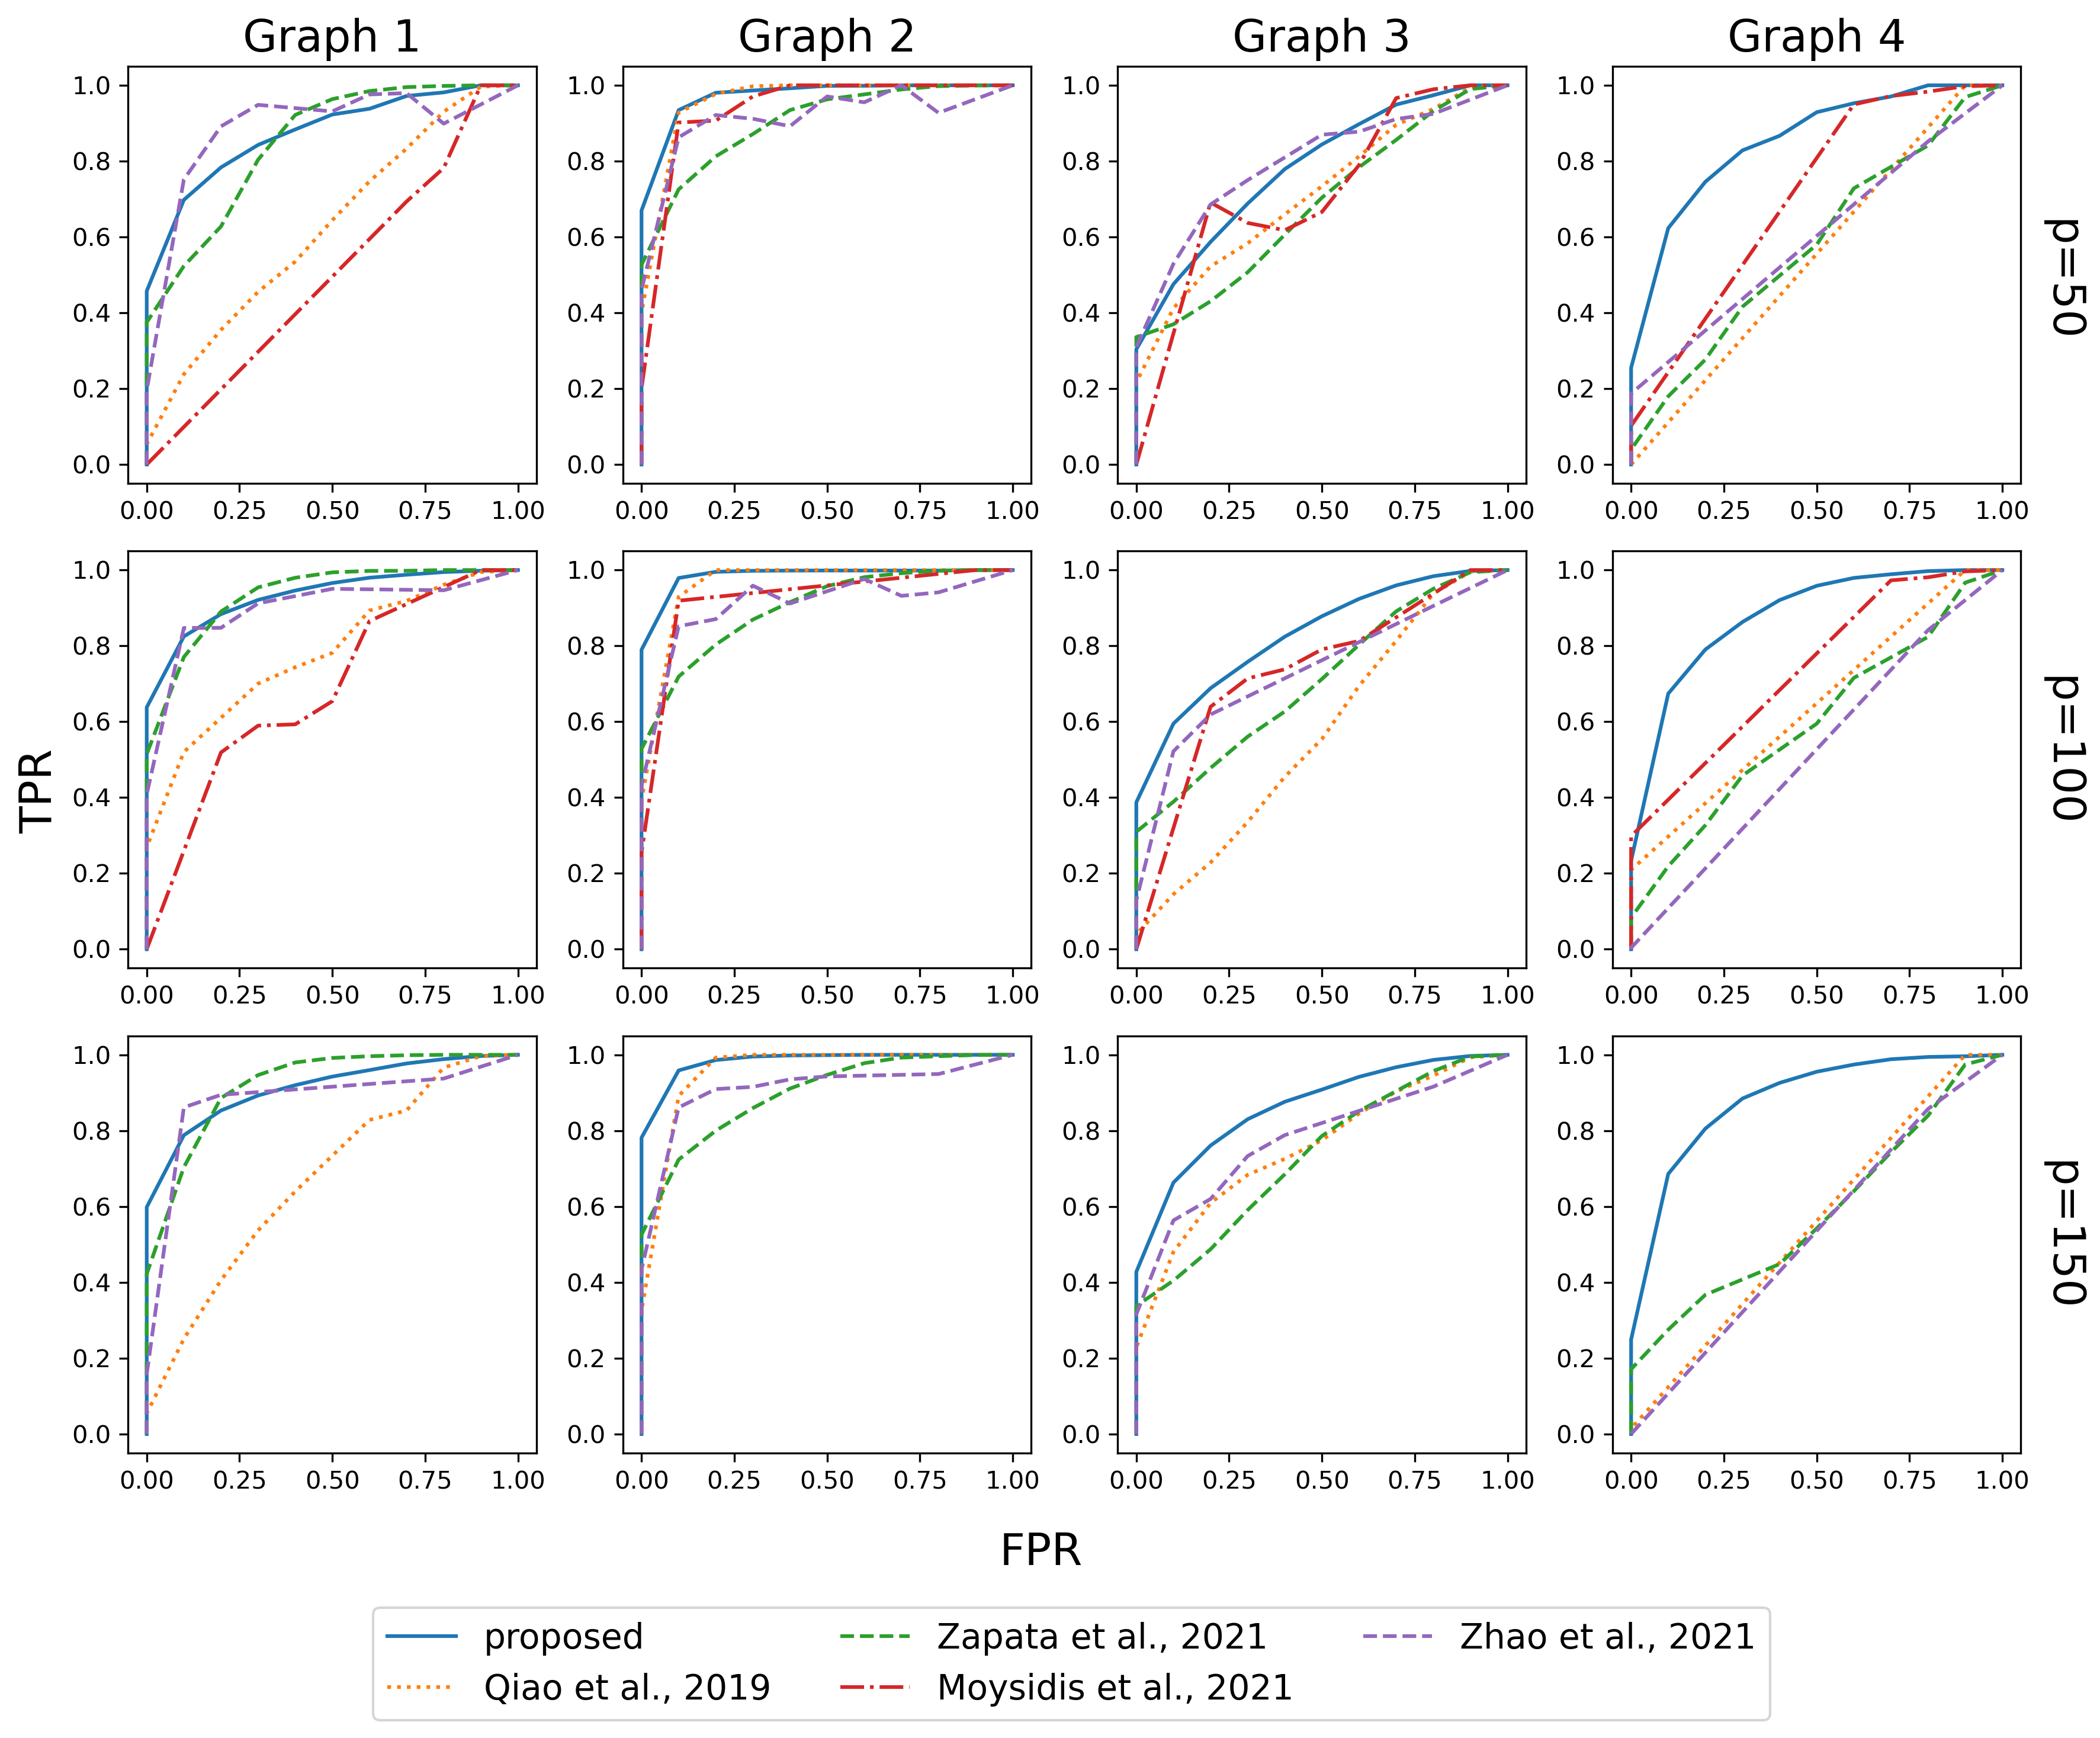

In [31]:
fig, ax = plt.subplots(3,4,figsize=(12, 9), dpi=300)

rate_list = [[332, 342, 443], [232, 232, 242], [232, 443, 443], [232, 232, 242]]

name_list = ['tridiag1', 'tridiag2', 'tridiag3', 'power']
p_list = [50, 100, 150]
fig.supxlabel('FPR',fontsize=18)
fig.supylabel('TPR',fontsize=18)
for i, name in enumerate(name_list):
    for j, p in enumerate(p_list):
        if j == 0:
            ax[j,i].set_title("Graph {}".format(i+1), fontsize=18)
        if i == 3:
            ax[j,i].text(1.1, 0.35, 'p={}'.format(p_list[j]),  fontsize=18, rotation=-90)
        test_model = '{}_p{}_N100'.format(name, p)
        model_path = '../../results/noise_model_1/model3/'
        rest_of_name = 'model3_{}_Iest_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model, rate_list[i][j])
        
        
        plot_mean_auc( ax[j,i], model_path, rest_of_name, label='proposed', linestyle='solid', color=color_map(0))

        cmodel_path = '../../results/noise_model_1/comparison/'
        rest_of_name = '{}_light.RunInd4.Rdata'.format(test_model)


        plot_mean_auc_joint(ax[j,i], cmodel_path, rest_of_name, label=['Qiao et al., 2019', 'Zapata et al., 2021'], linestyle=['dotted', 'dashed'], color = [color_map(1), color_map(2)])

        rest_of_name = '{}_jfggm_stage2_100.RunInd1.Rdata'.format(test_model)

        if  j <= 1:
            plot_mean_auc_jfggm(ax[j,i], cmodel_path, rest_of_name, label='Moysidis et al., 2021', linestyle='dashdot', color=color_map(3))
        nr_name = '{}_NR_RunInd4.Rdata'.format(test_model)
        plot_mean_auc_nr(ax[j,i], cmodel_path, nr_name, label='Zhao et al., 2021', linestyle='dashed', color=color_map(4))
handles, labels = ax[0,0].get_legend_handles_labels()
handles, labels = ax[0,0].get_legend_handles_labels()

fig.legend(handles, labels, ncol=3, bbox_to_anchor=(0.85, -0.0), prop={'size': 14})


fig.tight_layout()
fig.savefig('../../images/roc/compare_id2_average_horizontal2_ver2'+'.png', bbox_inches='tight')


### Plot ROC with Different N, noise model 2

file does not exist:../../results/noise_model_2/model3/ss_7/model3_power_p150_N100_Iest_noise3_thre0.001_rate242_run8_tprfpr.npy
file does not exist:../../results/noise_model_2/model3/ss_8/model3_power_p150_N100_Iest_noise3_thre0.001_rate242_run8_tprfpr.npy
file does not exist:../../results/noise_model_2/model3/ss_9/model3_power_p150_N100_Iest_noise3_thre0.001_rate242_run8_tprfpr.npy
file does not exist:../../results/noise_model_2/model3/ss_10/model3_power_p150_N100_Iest_noise3_thre0.001_rate242_run8_tprfpr.npy


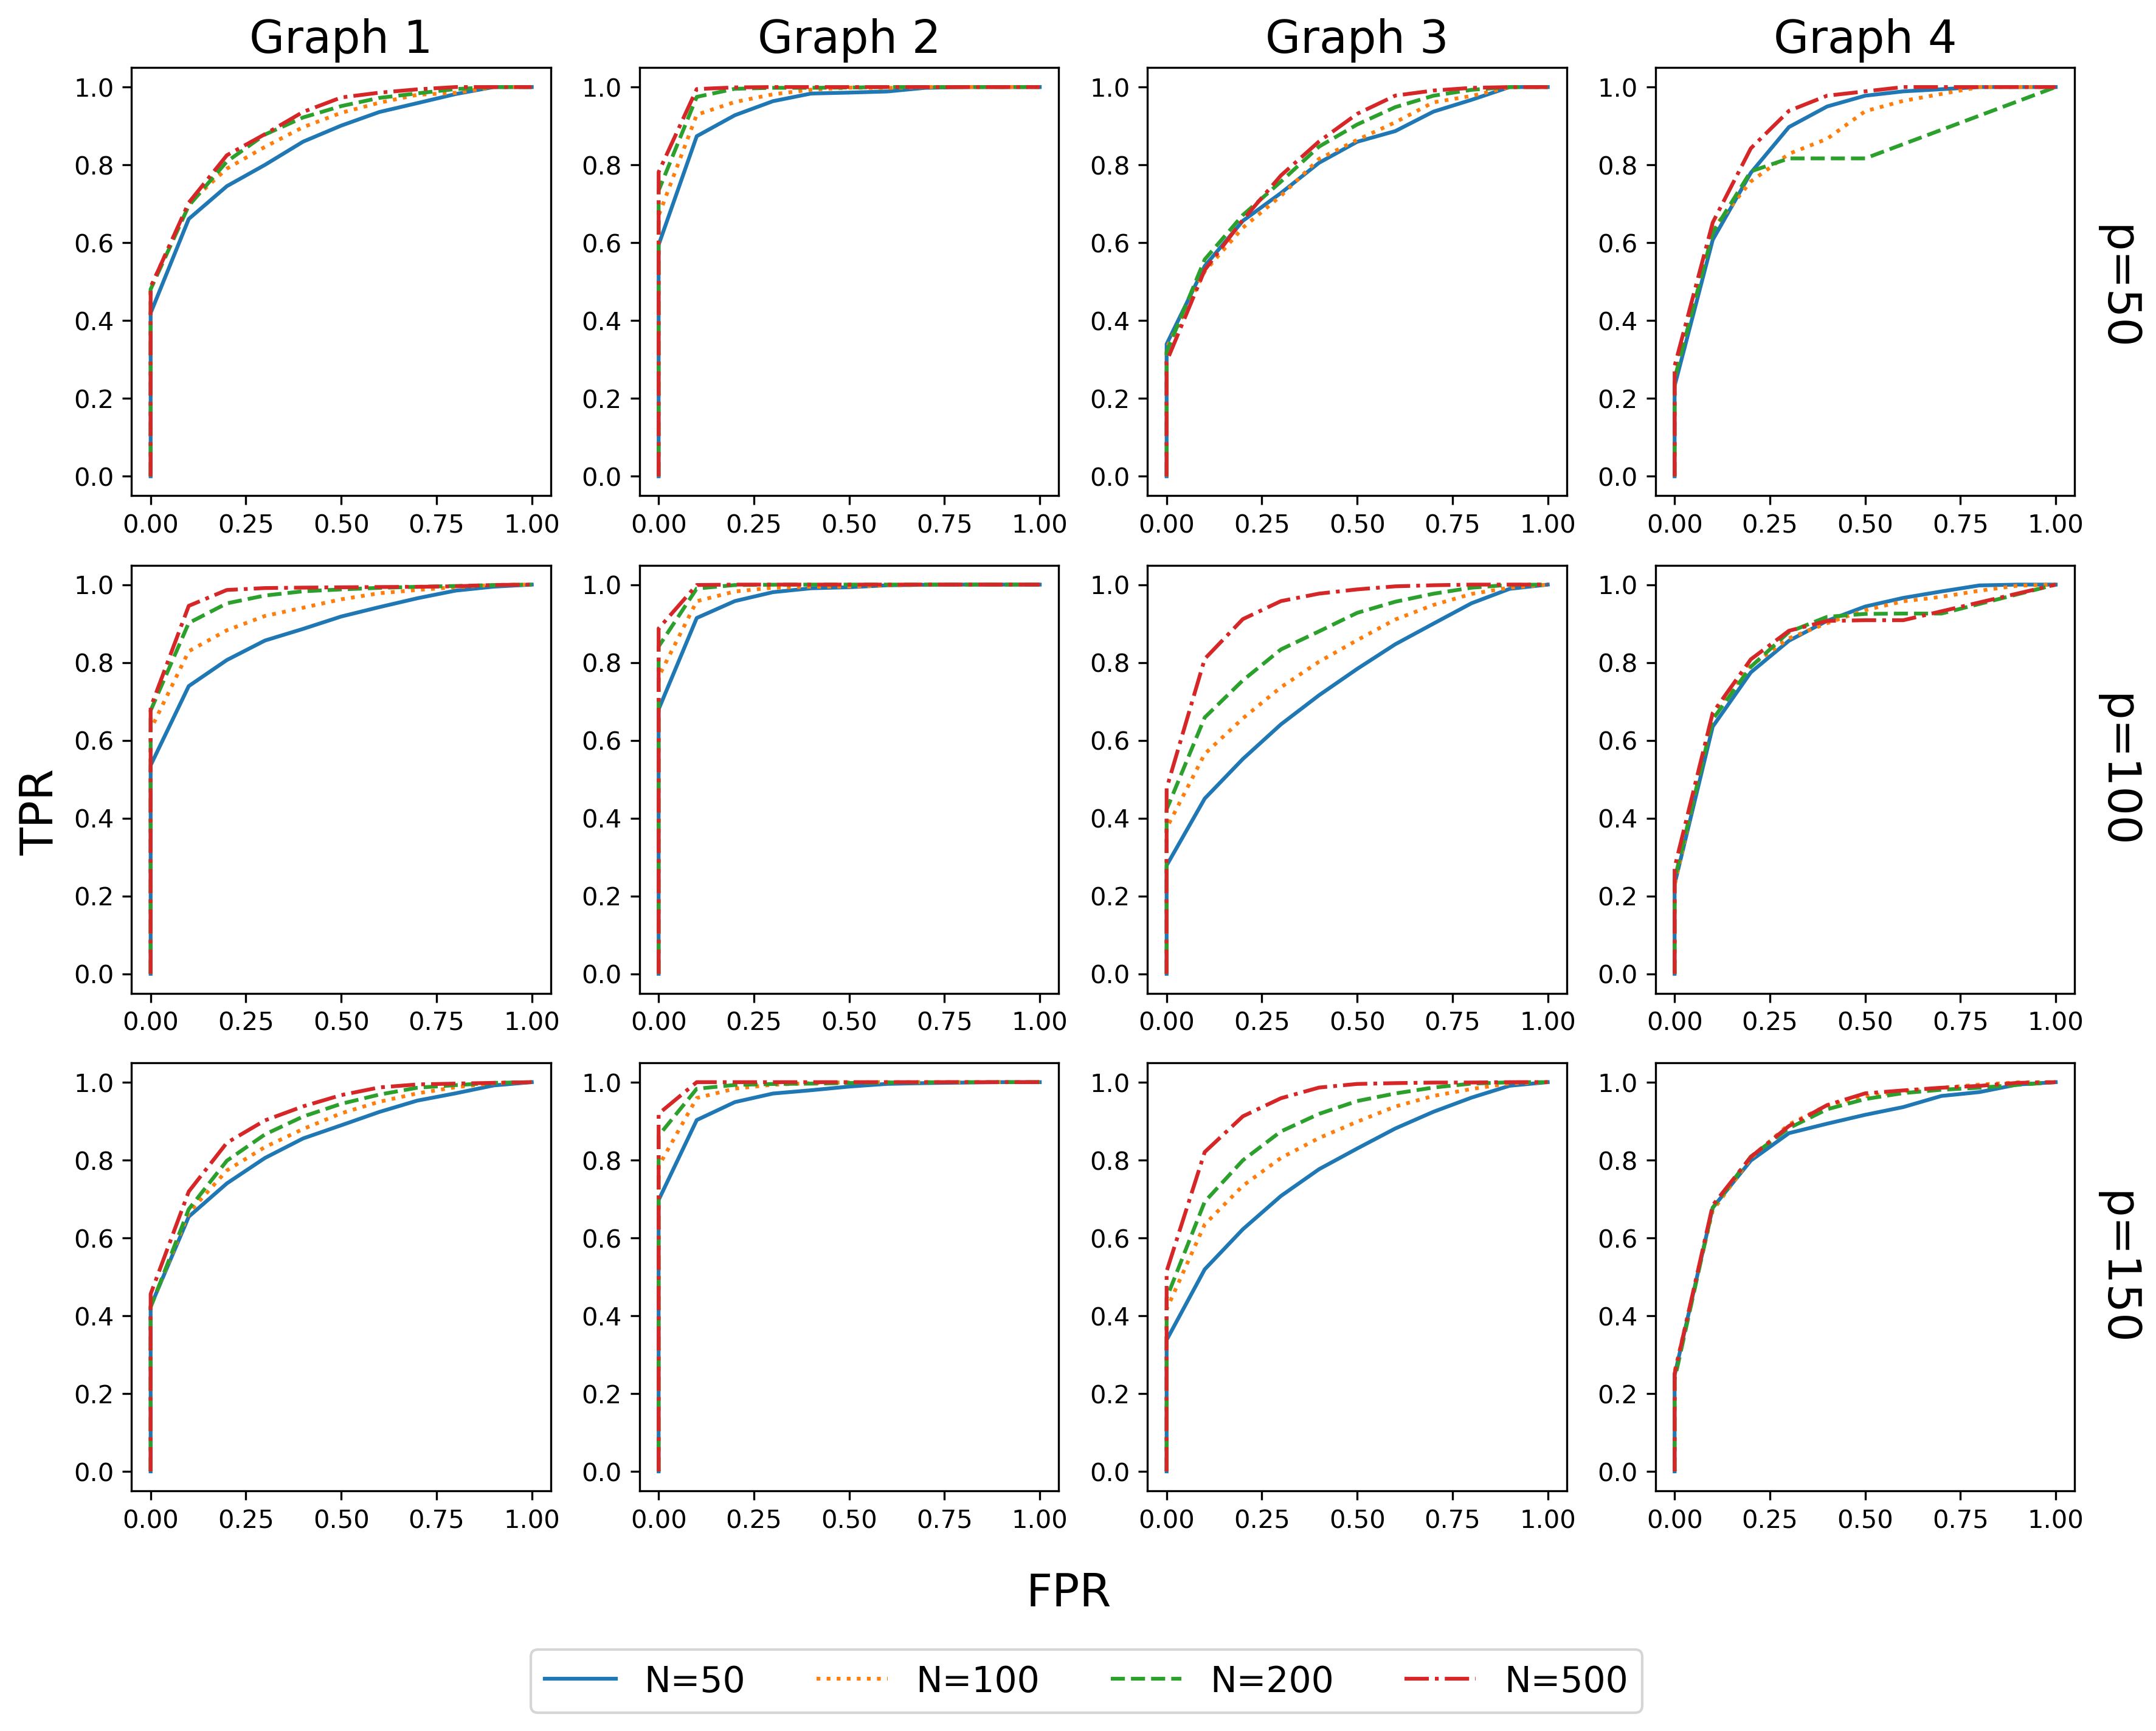

In [42]:
fig, ax = plt.subplots(3,4,figsize=(12, 9), dpi=300)
rate_list = [[332, 342, 343], [232, 232, 242], [232, 443, 443], [232, 232, 242]]
name_list = ['tridiag1', 'tridiag2', 'tridiag3', 'power']
line_list = ['solid','dotted', 'dashed','dashdot']
p_list = [50, 100, 150]
fig.supxlabel('FPR',fontsize=18)
fig.supylabel('TPR',fontsize=18)
for i, name in enumerate(name_list):
    for j, p in enumerate(p_list):
        if j == 0:
            ax[j,i].set_title("Graph {}".format(i+1), fontsize=18)
        if i == 3:
            ax[j,i].text(1.1, 0.35, 'p={}'.format(p_list[j]),  fontsize=18, rotation=-90)
        
        for k, N in enumerate([50,100,200,500]):
            test_model = '{}_p{}_N{}'.format(name, p, N)
            
            if N == 100:
                model_path = '../../results/noise_model_2/model3/'
            else: 
                model_path = '../../results/noise_model_2/model3_samplesize/'

            if test_model == 'tridiag1_p150_N50':
                rest_of_name = 'model3_{}_Iest_noise3_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model, 332)
            else:
                rest_of_name = 'model3_{}_Iest_noise3_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model, rate_list[i][j])

            plot_mean_auc( ax[j,i], model_path, rest_of_name, label='N={}'.format(N), linestyle=line_list[k], color=color_map(k))


handles, labels = ax[0,0].get_legend_handles_labels()

fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0.77, -0.0), prop={'size': 14})


fig.tight_layout()
#fig.savefig('../../images/roc/compare_id20_average_samplesize_horizontal'+'.pdf', bbox_inches='tight')


### Plot ROC with Different N, noise model 1

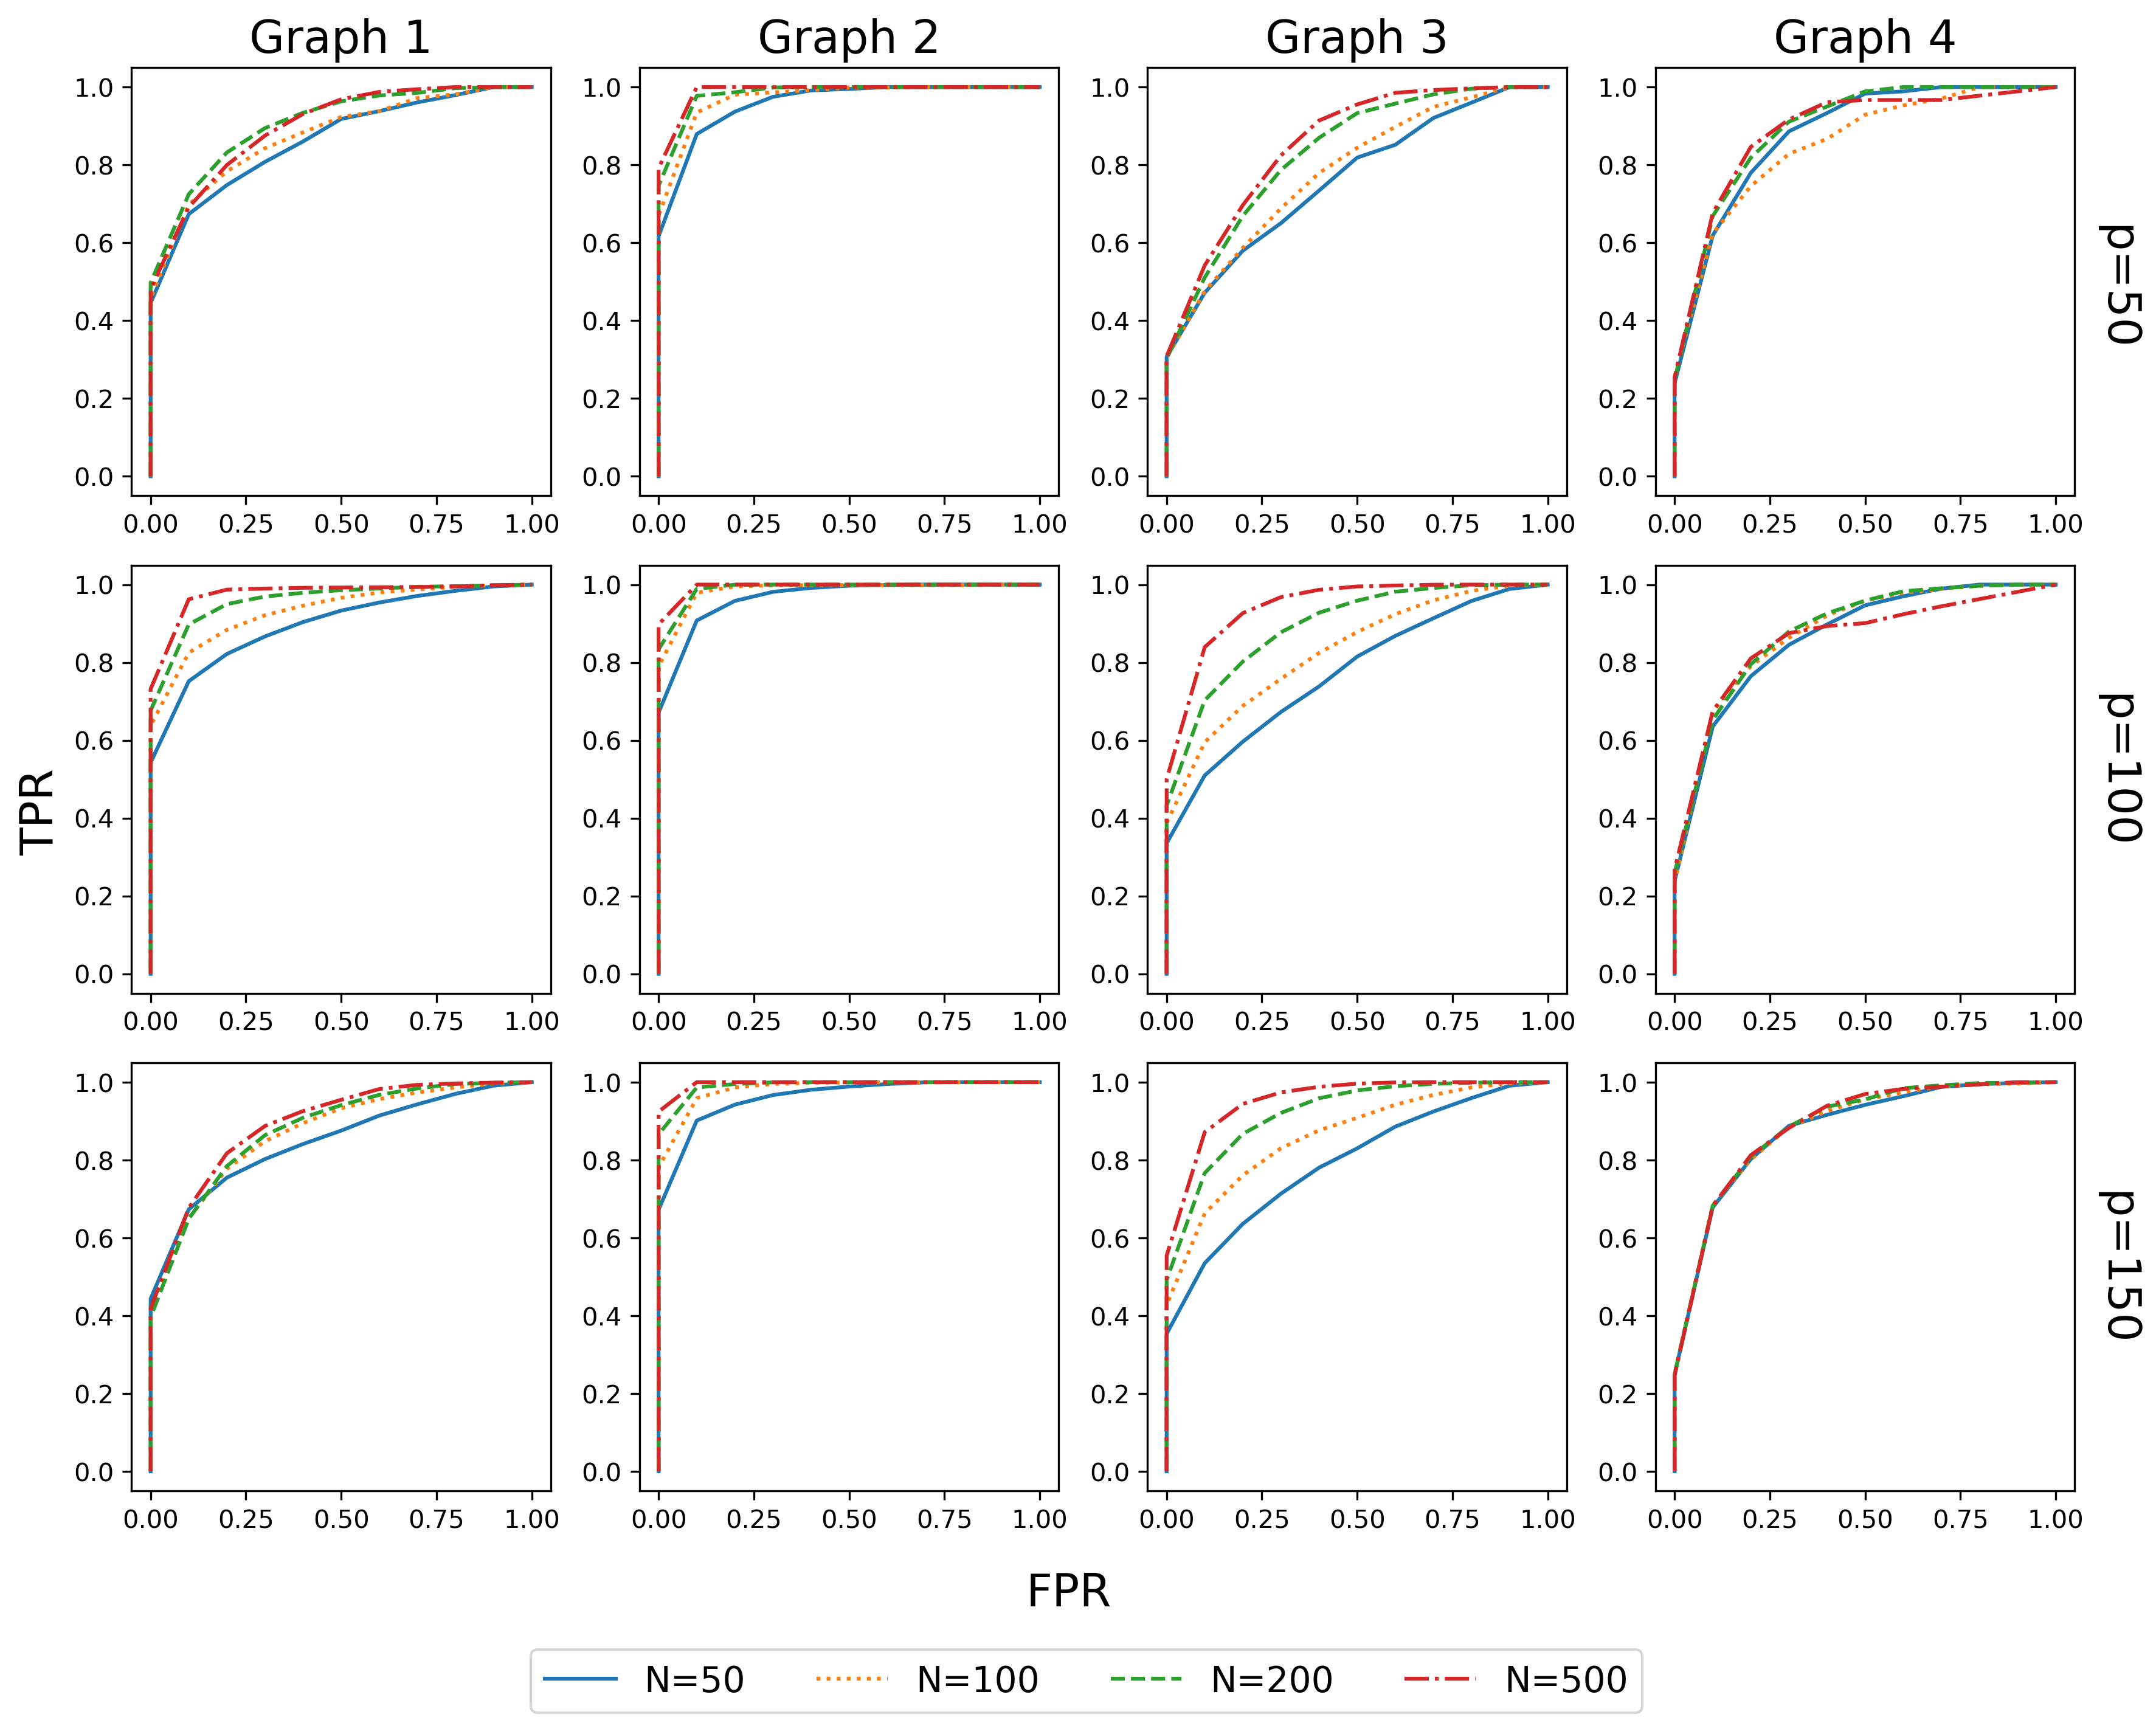

In [43]:
fig, ax = plt.subplots(3,4,figsize=(12, 9), dpi=300)
#for data20
rate_list = [[332, 342, 343], [232, 232, 242], [232, 443, 443], [232, 232, 232]]
name_list = ['tridiag1', 'tridiag2', 'tridiag3', 'power']
line_list = ['solid','dotted', 'dashed','dashdot']
p_list = [50, 100, 150]
fig.supxlabel('FPR',fontsize=18)
fig.supylabel('TPR',fontsize=18)
for i, name in enumerate(name_list):
    for j, p in enumerate(p_list):
        if j == 0:
            ax[j,i].set_title("Graph {}".format(i+1), fontsize=18)
        if i == 3:
            ax[j,i].text(1.1, 0.35, 'p={}'.format(p_list[j]),  fontsize=18, rotation=-90)
        
        for k, N in enumerate([50,100,200,500]):
            test_model = '{}_p{}_N{}'.format(name, p, N)
            
            if N == 100:
                model_path = '../../results/noise_model_1/model3/'
            else:
                model_path = '../../results/noise_model_1/model3_samplesize/' 

            if test_model == 'tridiag1_p150_N50':
                rest_of_name = 'model3_{}_Iest_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model, 332)
            else:
                rest_of_name = 'model3_{}_Iest_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model, rate_list[i][j])

            plot_mean_auc( ax[j,i], model_path, rest_of_name, label='N={}'.format(N), linestyle=line_list[k], color=color_map(k))


handles, labels = ax[0,0].get_legend_handles_labels()

fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0.77, -0.0), prop={'size': 14})


fig.tight_layout()


### Plot ROC with Different k, noise model 1

file does not exist:../../results/noise_model_1/model3/ss_4/model3_tridiag1_p50_N100_Iest_km9_k9_thre0.001_rate332_run8_tprfpr.npy
file does not exist:../../results/noise_model_1/model3/ss_5/model3_tridiag1_p50_N100_Iest_km9_k9_thre0.001_rate332_run8_tprfpr.npy
file does not exist:../../results/noise_model_1/model3/ss_4/model3_tridiag1_p100_N100_Iest_km9_k9_thre0.001_rate332_run8_tprfpr.npy
file does not exist:../../results/noise_model_1/model3/ss_5/model3_tridiag1_p100_N100_Iest_km9_k9_thre0.001_rate332_run8_tprfpr.npy
file does not exist:../../results/noise_model_1/model3/ss_4/model3_tridiag1_p150_N100_Iest_km9_k7_thre0.001_rate342_run8_tprfpr.npy
file does not exist:../../results/noise_model_1/model3/ss_5/model3_tridiag1_p150_N100_Iest_km9_k7_thre0.001_rate342_run8_tprfpr.npy
file does not exist:../../results/noise_model_1/model3/ss_4/model3_tridiag1_p150_N100_Iest_km9_k9_thre0.001_rate342_run8_tprfpr.npy
file does not exist:../../results/noise_model_1/model3/ss_5/model3_tridiag1_p1

/Users/katherinetsai/anaconda3/envs/mfggm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/katherinetsai/anaconda3/envs/mfggm/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katherinetsai/anaconda3/envs/mfggm/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/katherinetsai/anaconda3/envs/mfggm/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/Users/katherinetsai/anaconda3/envs/mfggm/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


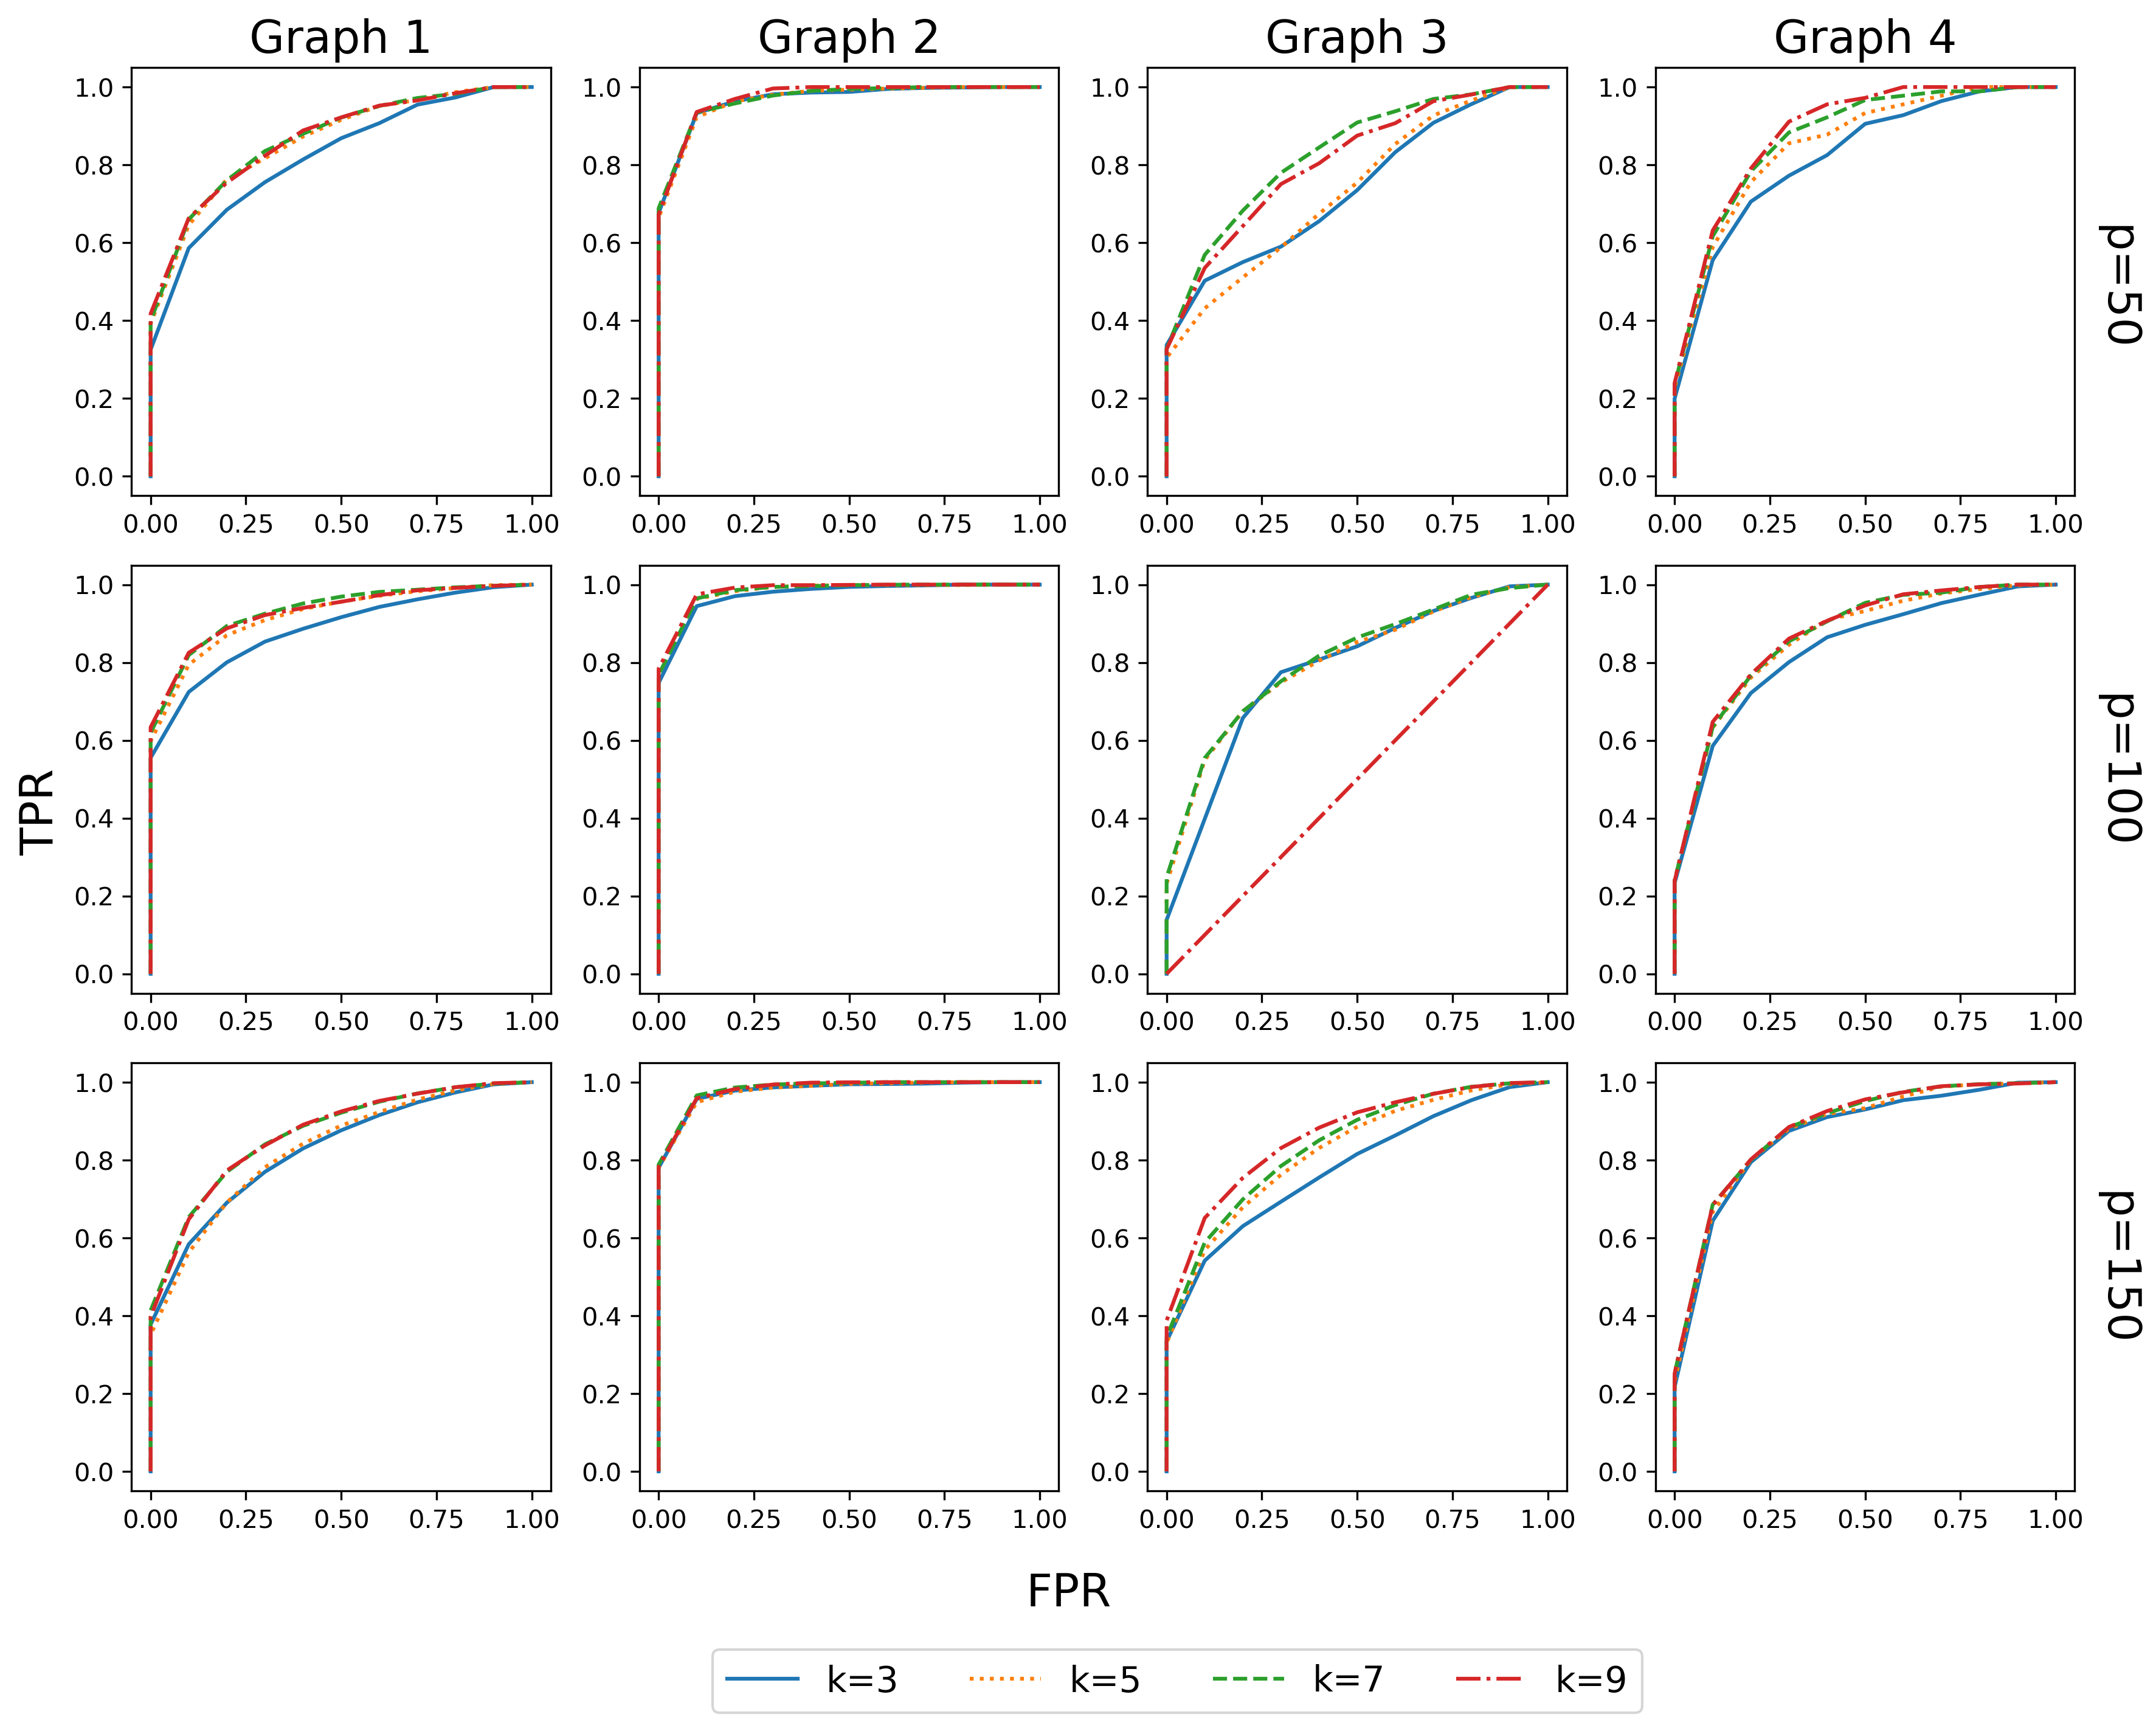

In [48]:
fig, ax = plt.subplots(3,4,figsize=(12, 9), dpi=300)
#for data20
rate_list = [[332, 332, 342], [232, 232, 242], [322, 443, 322], [232, 252, 232]]
name_list = ['tridiag1', 'tridiag2', 'tridiag3', 'power']
line_list = ['solid','dotted', 'dashed','dashdot','dotted']
p_list = [50, 100, 150]
fig.supxlabel('FPR',fontsize=18)
fig.supylabel('TPR',fontsize=18)
for i, name in enumerate(name_list):
    for j, p in enumerate(p_list):
        if j == 0:
            ax[j,i].set_title("Graph {}".format(i+1), fontsize=18)
        if i == 3:
            ax[j,i].text(1.1, 0.35, 'p={}'.format(p_list[j]),  fontsize=18, rotation=-90)
        
        test_model = '{}_p{}_N100'.format(name, p,)
    
        model_path = '../../results/noise_model_1/model3/'
        for idx, k in enumerate([ 3, 5, 7, 9]):
            rest_of_name = 'model3_{}_Iest_km9_k{}_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model,k, rate_list[i][j])
            if test_model == 'tridiag3_p100_N100':
                rest_of_name = 'model3_{}_Iest_km7_k{}_thre0.01_rate{}_run8_tprfpr.npy'.format(test_model,k, rate_list[i][j])
            plot_mean_auc( ax[j,i], model_path, rest_of_name, label='k={}'.format(k), linestyle=line_list[idx], color=color_map(idx))


handles, labels = ax[0,0].get_legend_handles_labels()

fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0.77, -0.0), prop={'size': 14})


fig.tight_layout()
